In [14]:
import geopandas as gpd
from shapely.geometry import LineString, Point
import os
import rasterio
from shapely.geometry import LineString
import pandas as pd
import rasterio
import geopandas as gpd
from shapely.geometry import LineString, Polygon, MultiPolygon, MultiLineString
from shapely.ops import unary_union


import matplotlib.pyplot as plt

from helpers import *

In [15]:
## # parameters
input_shapefile = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/lines/line_1.shp"
mine_boundary = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/INPUTS/Proposed/MIne Lease Boundary.shp"

output_folder_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/3d_data_output"
dtm_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/DEMs/DEM_itr_1.tif"

interval = 0.01  # 1 cm in meters

## interpolate the line
interpolated_line = interpolate_shapefile(input_path = input_shapefile, 
                                          output_path = os.path.join(output_folder_path, "interpolated_line.shp"), 
                                          interval_cm = 1)


## clip the line based on boundary 
clipped_line = clip_lines_by_boundary(line_shapefile = input_shapefile, 
                                      boundary_shapefile = mine_boundary ,
                                      output_shapefile = os.path.join(output_folder_path, "clipped_line.shp"))



## 


In [20]:
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString

# Load shapefiles
planned_and_done_excavation_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/Outputs/Shapefiles/Planned_and_Done_Excavation.shp"
#planned_and_not_done_excavation_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/Outputs/Shapefiles/Planned_and_Not_Done_Excavation.shp"
planned_and_used_dump_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/Outputs/Shapefiles/Planned_and_Used_Dump_Area.shp"
#planned_and_not_used_dump_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/Outputs/Shapefiles/Planned_and_Not_Used_Dump_Area.shp"
unplanned_and_used_dump_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/Outputs/Shapefiles/Unplanned_and_Used_Dump_Area.shp"
unplanned_and_done_excavation_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/Outputs/Shapefiles/Unplanned_and_Done_Excavation.shp"

polygon_gdf = gpd.read_file(planned_and_used_dump_path)
# Assuming line_gdf is already loaded

# Merge all polygons into one geometry
polygon_union = polygon_gdf.union_all()

# Get line geometry (assuming only one line, or loop through if multiple)
line_gdf = gpd.read_file("D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/3d_data_output/clipped_line.shp")
line_geom = line_gdf.geometry.iloc[0]

# Find the intersection between line and polygon
intersection = line_geom.intersection(polygon_union)

# Prepare list to hold LineStrings
line_segments = []

# Collect LineStrings or convert other geometry types
if intersection.is_empty:
    print("No intersection")
elif isinstance(intersection, LineString):
    line_segments.append(intersection)
elif isinstance(intersection, MultiLineString):
    for segment in intersection.geoms:
        line_segments.append(segment)
else:
    print("Other intersection type found:", type(intersection))

# Create GeoDataFrame from segments
intersect_gdf = gpd.GeoDataFrame(geometry=line_segments, crs=polygon_gdf.crs)

# Export to Shapefile (or change to '.geojson' or '.gpkg' if needed)
intersect_gdf.to_file("D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/3d_data_output/planned_and_used_dump_new_lines.shp")

print(f"Exported {len(intersect_gdf)} intersecting segments.")


No intersection
Exported 0 intersecting segments.


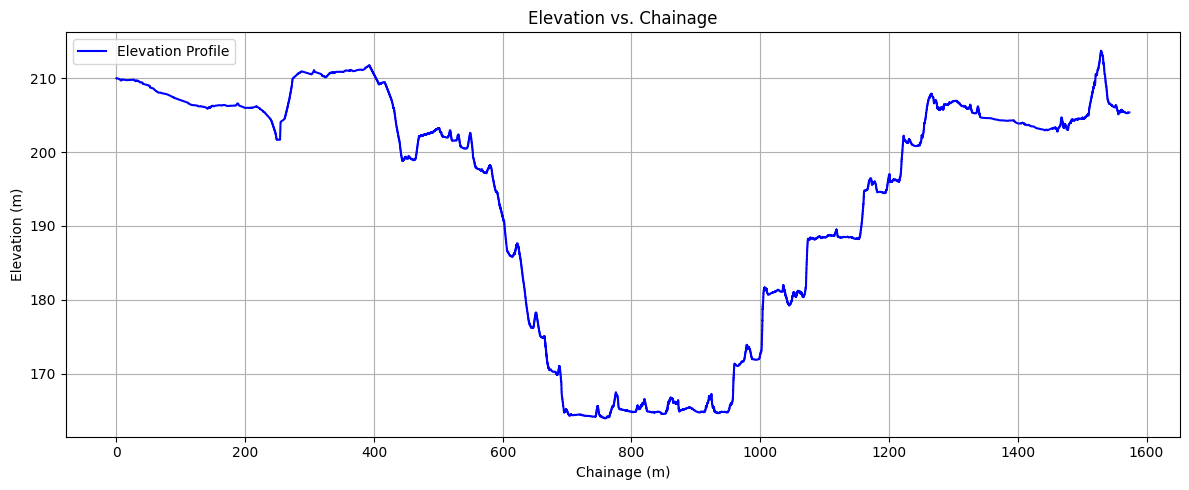

In [5]:
import os
import geopandas as gpd
import rasterio
from shapely.geometry import LineString, Point, MultiLineString
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Step 1: Elevation querying helper ----------
def elevation_at_point(dtm_src, x, y):
    """Query elevation value from DTM raster at (x, y) location."""
    q_ele = list(dtm_src.sample([(x, y)]))[0][0]
    return q_ele

# ---------- Step 2: Elevation sampling function ----------
def get_elevation_points_from_lines(dtm_path: str, clipped_line_shapefile: str, interval: float = 0.01):
    """
    For each point interpolated along lines, fetch elevation from DTM.
    """
    lines_gdf = gpd.read_file(clipped_line_shapefile)

    with rasterio.open(dtm_path) as dtm_src:
        if lines_gdf.crs != dtm_src.crs:
            print("Reprojecting line geometries to match DTM CRS...")
            lines_gdf = lines_gdf.to_crs(dtm_src.crs)

        points_with_elevation = []

        for geom in lines_gdf.geometry:
            if isinstance(geom, LineString):
                length = geom.length
                num_points = int(length // interval) + 1
                distances = [i * interval for i in range(num_points + 1)]

                for d in distances:
                    pt = geom.interpolate(d)
                    x, y = pt.x, pt.y
                    z = elevation_at_point(dtm_src, x, y)
                    points_with_elevation.append((x, y, z))

        return points_with_elevation

# ---------- Step 3: Paths ----------
dtm_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/DEMs/DEM_itr_1.tif"
clipped_line_shapefile = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/3d_data_output/clipped_line.shp"

# ---------- Step 4: Get elevation points ----------
points_with_elevation = get_elevation_points_from_lines(dtm_path, clipped_line_shapefile, interval=0.01)

# ---------- Step 5: Convert to DataFrame and Plot ----------
df = pd.DataFrame(points_with_elevation, columns=["x", "y", "z"])
df["chainage"] = [0.01 * i for i in range(len(df))]

plt.figure(figsize=(12, 5))
plt.plot(df["chainage"], df["z"], label="Elevation Profile", color="blue")
plt.xlabel("Chainage (m)")
plt.ylabel("Elevation (m)")
plt.title("Elevation vs. Chainage")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


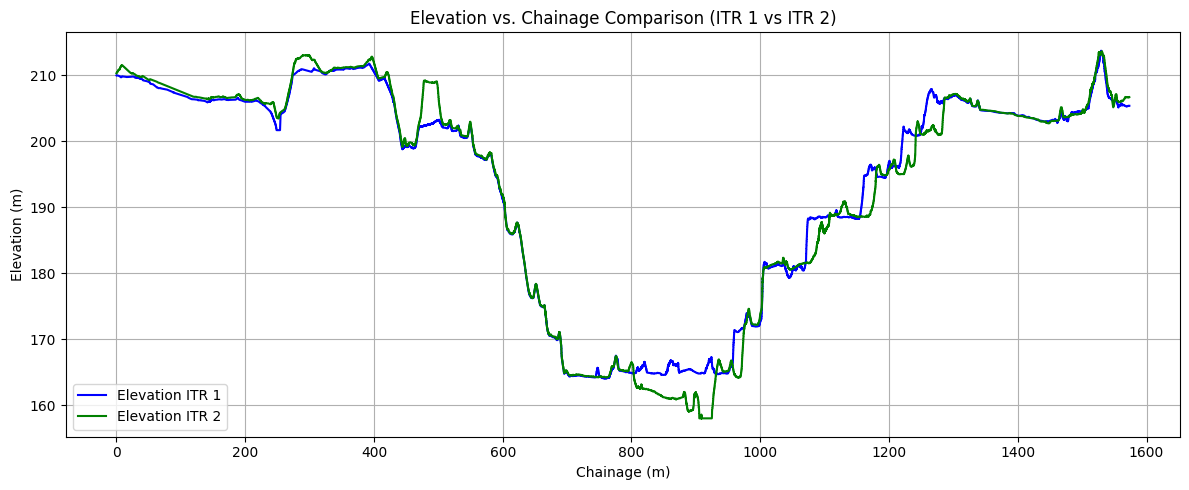

In [ ]:


# ---------- Step 1: Elevation querying helper ----------
def elevation_at_point(dtm_src, x, y):
    """Query elevation value from DTM raster at (x, y) location."""
    q_ele = list(dtm_src.sample([(x, y)]))[0][0]
    return q_ele

# ---------- Step 2: Elevation sampling function ----------
def get_elevation_points_from_lines(dtm_path: str, clipped_line_shapefile: str, interval: float = 0.01):
    """
    For each point interpolated along lines, fetch elevation from DTM.
    Returns: List of (x, y, z) tuples.
    """
    lines_gdf = gpd.read_file(clipped_line_shapefile)

    with rasterio.open(dtm_path) as dtm_src:
        if lines_gdf.crs != dtm_src.crs:
            print("Reprojecting line geometries to match DTM CRS...")
            lines_gdf = lines_gdf.to_crs(dtm_src.crs)

        points_with_elevation = []

        for geom in lines_gdf.geometry:
            if isinstance(geom, LineString):
                length = geom.length
                num_points = int(length // interval) + 1
                distances = [i * interval for i in range(num_points + 1)]

                for d in distances:
                    pt = geom.interpolate(d)
                    x, y = pt.x, pt.y
                    z = elevation_at_point(dtm_src, x, y)
                    points_with_elevation.append((x, y, z))

        return points_with_elevation

# ---------- Step 3: Paths ----------
clipped_line_shapefile = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/3d_data_output/clipped_line.shp"
dtm1_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/DEMs/DEM_itr_1.tif"
dtm2_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/DEMs/DEM_itr_2.tif"

# ---------- Step 4: Get elevation profiles ----------
elevations_itr1 = get_elevation_points_from_lines(dtm1_path, clipped_line_shapefile, interval=0.01)
elevations_itr2 = get_elevation_points_from_lines(dtm2_path, clipped_line_shapefile, interval=0.01)

# ---------- Step 5: Convert to DataFrame ----------
df1 = pd.DataFrame(elevations_itr1, columns=["x", "y", "z"])
df1["chainage"] = [0.01 * i for i in range(len(df1))]

df2 = pd.DataFrame(elevations_itr2, columns=["x", "y", "z"])
df2["chainage"] = [0.01 * i for i in range(len(df2))]

# ---------- Step 6: Plot ----------
plt.figure(figsize=(12, 5))
plt.plot(df1["chainage"], df1["z"], label="Elevation ITR 1", color="blue")
plt.plot(df2["chainage"], df2["z"], label="Elevation ITR 2", color="green")
plt.xlabel("Chainage (m)")
plt.ylabel("Elevation (m)")
plt.title("Elevation vs. Chainage Comparison (ITR 1 vs ITR 2)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
